# 1D MT parametric inversion

## Learning goals

- Run 1D MT inversion for the same field data that you conducted a manual parametric fitting.

In [1]:
import numpy as np
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import maps
import matplotlib.pyplot as plt
import matplotlib
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)

In [2]:
from mtpy import MTCollection
mc = MTCollection()
mc.open_collection(r"../data/yellowstone_mt_collection.h5")

from ipywidgets import widgets, interact
station_names = mc.dataframe.station.values
def foo(name):
    tf = mc.get_tf(name)
    tf.plot_mt_response()

GDAL_DATA environment variable is not set  Please see https://trac.osgeo.org/gdal/wiki/FAQInstallationAndBuilding#HowtosetGDAL_DATAvariable 


Ignore GDAL as it is not working. Will use pyproj


2022-10-10 16:36:55,494 [line 135] error.get_mtpy_logger - INFO: Logging file can be found C:\Users\sgkan\anaconda3\envs\em\lib\site-packages\mtpy-2.0.0-py3.9.egg\logs\mtpy_error.log
2022-10-10 16:36:57,995 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\sgkan\anaconda3\envs\em\lib\site-packages\mth5-0.3.0-py3.9.egg\logs\mth5_debug.log


In [3]:
Q = interact(foo, name=widgets.Select(options=station_names, value='YNP05S'))

interactive(children=(Select(description='name', index=144, options=('IDD11', 'IDD12', 'IDE11', 'IDE12', 'IDF1…

2022-10-10 16:37:00,856 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID YNP05S. Suggest setting survey, otherwise returning the TF from survey YSBB.


Text(0.5, 1.0, 'YNP05S')

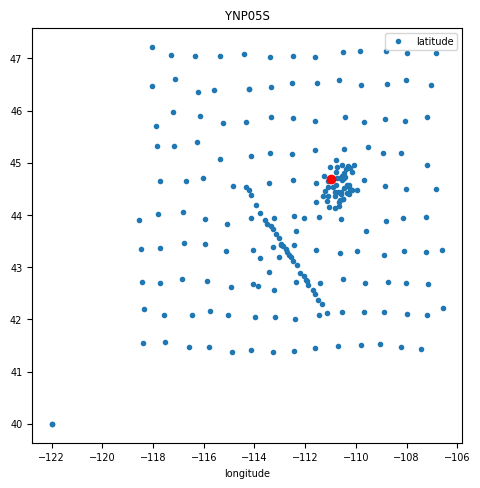

In [4]:
name = Q.widget.kwargs['name']
tf = mc.get_tf(name)
fig, ax = plt.subplots(1,1, figsize=(5,5))
mc.dataframe.plot(x='longitude', y='latitude', marker='.', linestyle='None', ax=ax)
ax.plot(tf.longitude, tf.latitude, 'ro')
ax.set_title(name)

In [5]:
frequencies = 1./tf.period
n_layer = 5
wire_map = maps.Wires(("sigma", n_layer), ("t", n_layer - 1))
sigma_map = maps.ExpMap(nP=n_layer) * wire_map.sigma
layer_map = maps.ExpMap(nP=n_layer - 1) * wire_map.t


model_mapping = maps.IdentityMap(nP=n_layer)

receivers_list = [
    nsem.receivers.PointNaturalSource(component="app_res"),
    nsem.receivers.PointNaturalSource(component="phase"),
]

source_list = []
for freq in frequencies:
    source_list.append(nsem.sources.Planewave(receivers_list, freq))

survey = nsem.survey.Survey(source_list)

simulation = nsem.simulation_1d.Simulation1DRecursive(
    survey=survey, 
    sigmaMap=sigma_map,
    thicknessesMap=layer_map,
)

(array([16.,  1.,  2.,  7.,  4.,  3.,  1.,  1.,  1.,  1.]),
 array([0.00749597, 0.09818962, 0.18888327, 0.27957691, 0.37027056,
        0.46096421, 0.55165786, 0.6423515 , 0.73304515, 0.8237388 ,
        0.91443245]),
 <BarContainer object of 10 artists>)

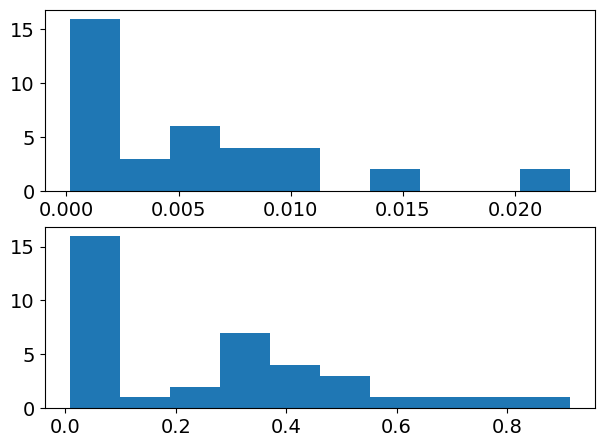

In [6]:
matplotlib.rcParams['font.size'] = 14
fig, axs = plt.subplots(2,1)
ax1, ax2 = axs
ax1.hist(tf.Z.res_err_det/tf.Z.res_det)
ax2.hist(tf.Z.phase_err_det)

In [7]:
app_rho = tf.Z.res_det.copy()
phase = tf.Z.phase_det.copy()
std = np.c_[abs(app_rho)*0.03, np.ones(len(phase))*2].flatten()
noise = np.c_[np.random.randn(app_rho.size)*0.03*abs(app_rho), np.random.randn(app_rho.size)*2].flatten()
dobs = np.c_[app_rho, phase].flatten()
data_object = data.Data(survey, dobs=dobs, standard_deviation=std)

In [8]:
starting_model = np.log(np.r_[np.ones(n_layer)*1./100, np.ones(n_layer-1)*1000])

In [9]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
mesh = TensorMesh([n_layer])
# Define the regularization on the parameters related to resistivity
mesh_sigma = TensorMesh([mesh.hx.size])
reg_sigma = regularization.Simple(mesh_sigma, alpha_s=0.01, alpha_x=0, mapping=wire_map.sigma)

# Define the regularization on the parameters related to layer thickness
mesh_t = TensorMesh([mesh.hx.size - 1])
reg_t = regularization.Simple(mesh_t, alpha_s=0.01, alpha_x=0, mapping=wire_map.t)

# Combine to make regularization for the inversion problem
reg = reg_sigma + reg_t

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter=30, maxIterCG=50)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

#######################################################################
# Define Inversion Directives
# ---------------------------
#
# Here we define any directives that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.
#

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weights = directives.UpdateSensitivityWeights()

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=5.0, coolingRate=3)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined in a list
directives_list = [
    update_sensitivity_weights,
    starting_beta,
    beta_schedule,
    target_misfit,
]

#####################################################################
# Running the Inversion
# ---------------------
#
# To define the inversion object, we need to define the inversion problem and
# the set of directives. We can then run the inversion.
#

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


C:\Users\sgkan\Projects\pymatsolver\pymatsolver\direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
C:\Users\sgkan\Projects\pymatsolver\pymatsolver\direct.py:73: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


   0  2.92e+07  1.73e+04  0.00e+00  1.73e+04    3.72e+04      0              
   1  2.92e+07  9.14e+03  1.04e-04  1.22e+04    4.33e+03      0              
   2  2.92e+07  9.44e+03  8.64e-05  1.20e+04    6.77e+02      0              
   3  5.84e+06  9.30e+03  9.12e-05  9.83e+03    1.35e+04      0              
   4  5.84e+06  5.23e+03  5.07e-04  8.19e+03    2.13e+03      0              
   5  5.84e+06  5.65e+03  4.17e-04  8.09e+03    1.28e+03      0              
   6  1.17e+06  5.52e+03  4.21e-04  6.01e+03    5.77e+03      0              
   7  1.17e+06  2.55e+03  2.94e-03  5.99e+03    4.65e+03      0              
   8  1.17e+06  2.84e+03  1.95e-03  5.12e+03    3.56e+03      0              
   9  2.34e+05  2.23e+03  2.15e-03  2.73e+03    2.54e+03      0              
  10  2.34e+05  5.16e+02  6.29e-03  1.99e+03    2.46e+03      0              
  11  2.34e+05  3.11e+02  5.57e-03  1.61e+03    3.38e+02      0              
  12  4.68e+04  2.92e+02  5.52e-03  5.50e+02    6.57e+02      0 

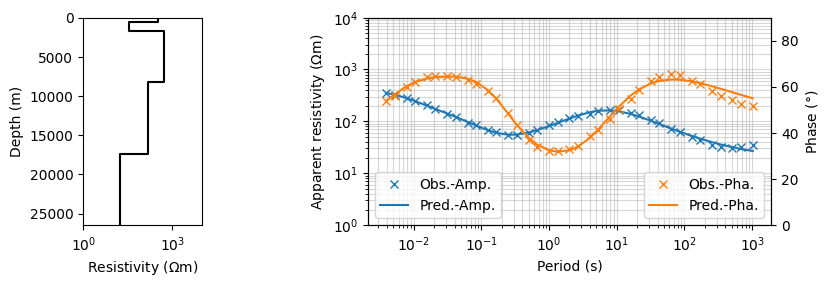

In [10]:
import matplotlib.gridspec as gridspec
matplotlib.rcParams['font.size'] = 10
fig = plt.figure(figsize=(16*0.5, 5*0.5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
x_min = 1
x_max = 1000

plot_1d_layer_model(
    (layer_map * recovered_model)[::-1],
    (1./(sigma_map * recovered_model))[::-1],
    ax=ax0,
    color="k"
)
ax0.set_xlabel("Resistivity ($\Omega$m)")
ax0.set_xlim(1, 1e4)

ax = fig.add_subplot(gs[0, 2:])
ax.loglog(1./frequencies, dobs.reshape((len(frequencies), 2))[:,0], 'x', color='C0', label='Obs.-Amp.')
ax.loglog(1./frequencies, inv_prob.dpred.reshape((len(frequencies), 2))[:,0], color='C0', label='Pred.-Amp.')
ax_1 = ax.twinx()
ax_1.plot(1./frequencies, dobs.reshape((len(frequencies), 2))[:,1], 'x', color='C1', label='Obs.-Pha.')
ax_1.plot(1./frequencies, inv_prob.dpred.reshape((len(frequencies), 2))[:,1], color='C1', label='Pred.-Pha.')
ax.set_xlabel("Period (s)")
ax.grid(True, which='both', alpha=0.5)
ax.set_ylabel("Apparent resistivity ($\Omega$m)")
ax_1.set_ylabel("Phase ($\degree$)")
ax.legend(bbox_to_anchor=(1.1,1))
ax.legend(loc=3)
ax_1.legend(loc=4)
ax.set_ylim(1, 10000)
ax_1.set_ylim(0, 90)    
ax0.set_xlim(1, 10000)
plt.show()